In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.sparse import csc_matrix
import math
mat_contents = sio.loadmat('kos_doc_data.mat')
mat_contents2= sio.loadmat('store_b.mat')

In [35]:
def sampDiscrete(b):
    r = np.sum(b)*np.random.uniform(0,1,1)
    a = b[0]; i = 0
    while a < r:
        i+=1
        if i == 20-1:
            break
        a+=b[i]
    return i

In [2]:
A = mat_contents['A'] # train
B = mat_contents['B'] # test
V = mat_contents['V'] # vocabulary list

print('Min ID of documents in A: '+str(A[:,0].min()))
print('Max ID of documents in A: '+str(A[:,0].max()))
print('No. of distinct words from A: '+str(A[:,1].max()))
print('No. of distinct word occurences in As doc: '+str(A[:,2].max()))

print('Min ID of documents in B: '+str(B[:,0].min()))
print('Max ID of documents in B: '+str(B[:,0].max()))
print('No. of distinct words from B: '+str(B[:,1].max()))
print('No. of distinct word occurences in Bs doc: '+str(B[:,2].max()))

print('No. of distinct words frBom V: '+str(len(V)))

Min ID of documents in A: 1
Max ID of documents in A: 2000
No. of distinct words from A: 6906
No. of distinct word occurences in As doc: 29
Min ID of documents in B: 2001
Max ID of documents in B: 3430
No. of distinct words from B: 6906
No. of distinct word occurences in Bs doc: 43
No. of distinct words frBom V: 6906


In [53]:
store_b = mat_contents2['b']
print(store_b.shape)

(1, 6906)


In [4]:
W = A[:,1].max(); D = A[:,0].max(); K = 20
alpha = .1; gamma = .1

In [56]:
swd = csc_matrix((A[:,2],(A[:,1]-1,A[:,0]-1)))
Swd = csc_matrix((B[:,2],(B[:,1]-1,B[:,0]-1)))
skd = np.zeros((K,D))
swk = np.zeros((W,K))
s = []
for d in range(D):
    z = np.zeros((W,K))
    for w in A[A[:,0]==d+1,1]:
        c = swd[w-1,d]
        for i in range(c):
            k = np.ceil(K*np.random.uniform(0,1,1)).astype(int)
            z[w-1,k-1] += 1
    skd[:,d] = np.sum(z,axis=0)   
    swk += z
    s.append(csc_matrix(z))
    
sk = np.sum(skd,axis=1)
topic_mixpro = []; entropy = np.zeros((20,20))

In [58]:
for itr in range(100):
    for d in range(D):
        z = s[d].toarray()
        for w in A[A[:,0]==d+1,1]:
            a = z[w-1,:]; ka = np.where(a)
            for k in ka[0][np.random.permutation(len(ka))]:
                for i in range(a[k].astype(int)):
                    z[w-1,k-1] -= 1; swk[w-1,k-1] -= 1
                    sk[k-1] -= 1; skd[k-1,d] -= 1
                    b=(alpha+skd[:,d])*(gamma+swk[w-1,:])/(W*gamma+sk)
                    kk = sampDiscrete(b)
                    z[w-1,kk] += 1; skd[kk,d] += 1
                    swk[w-1,kk] += 1; sk[kk] += 1   
        s[d] = csc_matrix(z)
    topic_mixpro.append(sk/np.sum(sk))
    for j in range(20):
        topic_s = swk[:,j]
        en = 0
        for wo in range(6906):
            if topic_s[wo] == 0:
                en = en
            else:
                en -= store_b[0,wo]*np.log(store_b[0,wo])
        entropy[j,itr] = en

#     break

KeyboardInterrupt: 

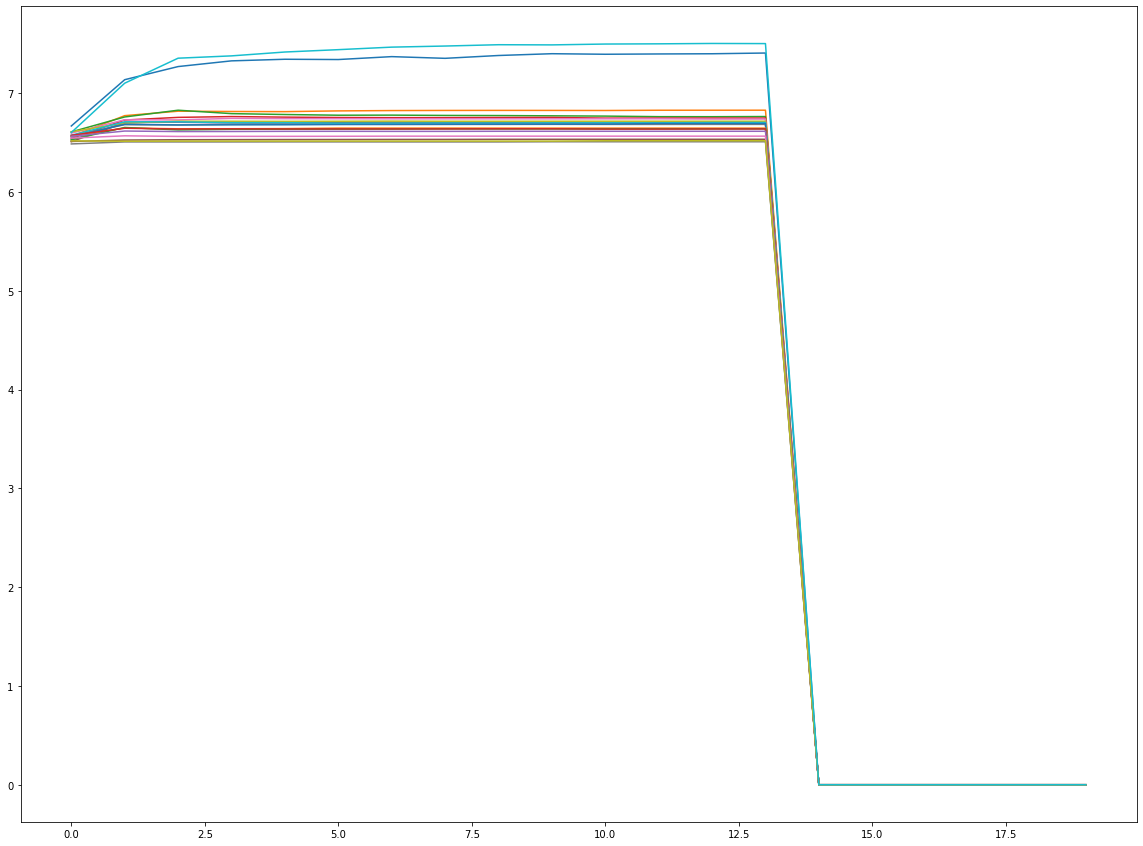

In [62]:
plt.figure(figsize=(20,15))
for i in range(20):
    plt.plot(np.arange(20),entropy[i,:])

In [60]:
itr

14

In [ ]:
lp = 0; nd = 0;
for d in np.unique(B[:,0]):
    z = np.zeros((W,K))
    for w in B[B[:,0]==d+1,1]:
        for i in range(Swd[w-1,d]):
            k = np.ceil(K*np.random.uniform(0,1,1)).astype(int)
            z[w-1,k-1] += 1
    Skd = np.sum(z,axis=0)
    Sk = sk+Skd
    for itr in range(100):
        for w in B[B[:,0]==d+1,1]:
            a = z[w-1,:]; ka = np.where(a)
            for k in ka[0][np.random.permutation(len(ka))]:
                for i in range(a[k].astype(int)):
                    z[w-1,k-1] -= 1; Skd[k-1] -= 1
                    b=(alpha+Skd)*(gamma+swk[w-1,:])/(W*gamma+sk)
                    kk = sampDiscrete(b)
                    z[w-1,kk] += 1; Skd[kk] += 1
    b=(alpha+Skd)/np.sum(alpha+Skd)*((gamma+swk)/(W*gamma+sk))
    w = B[B[:,0]==d+1,1:]
    lp += w[:,1]*np.log(b[w[:,0]])
    nd += np.sum(w[:,1])
perplexity = np.exp(-lp/nd)